In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import random
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
# Parameters
im_shape = (224, 224) # images input size
batch_size = 64 # how big is a set of images use for propagation when training at once
                # (smaller is better but takes longer to train)
seed = 87 # seed for data splitting randomization

## Data Preparation

In [3]:
# Define path to input files
base_path = os.path.join(".","garbage_classification")

# Define classification classes
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

In [4]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [5]:
filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(os.path.join(base_path, category))
    
    filenames_list += filenames
    categories_list += [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,filename,category
0,clothes/clothes1791.jpg,clothes
1,shoes/shoes151.jpg,shoes
2,white-glass/white-glass753.jpg,white-glass
3,trash/trash277.jpg,trash
4,battery/battery76.jpg,battery


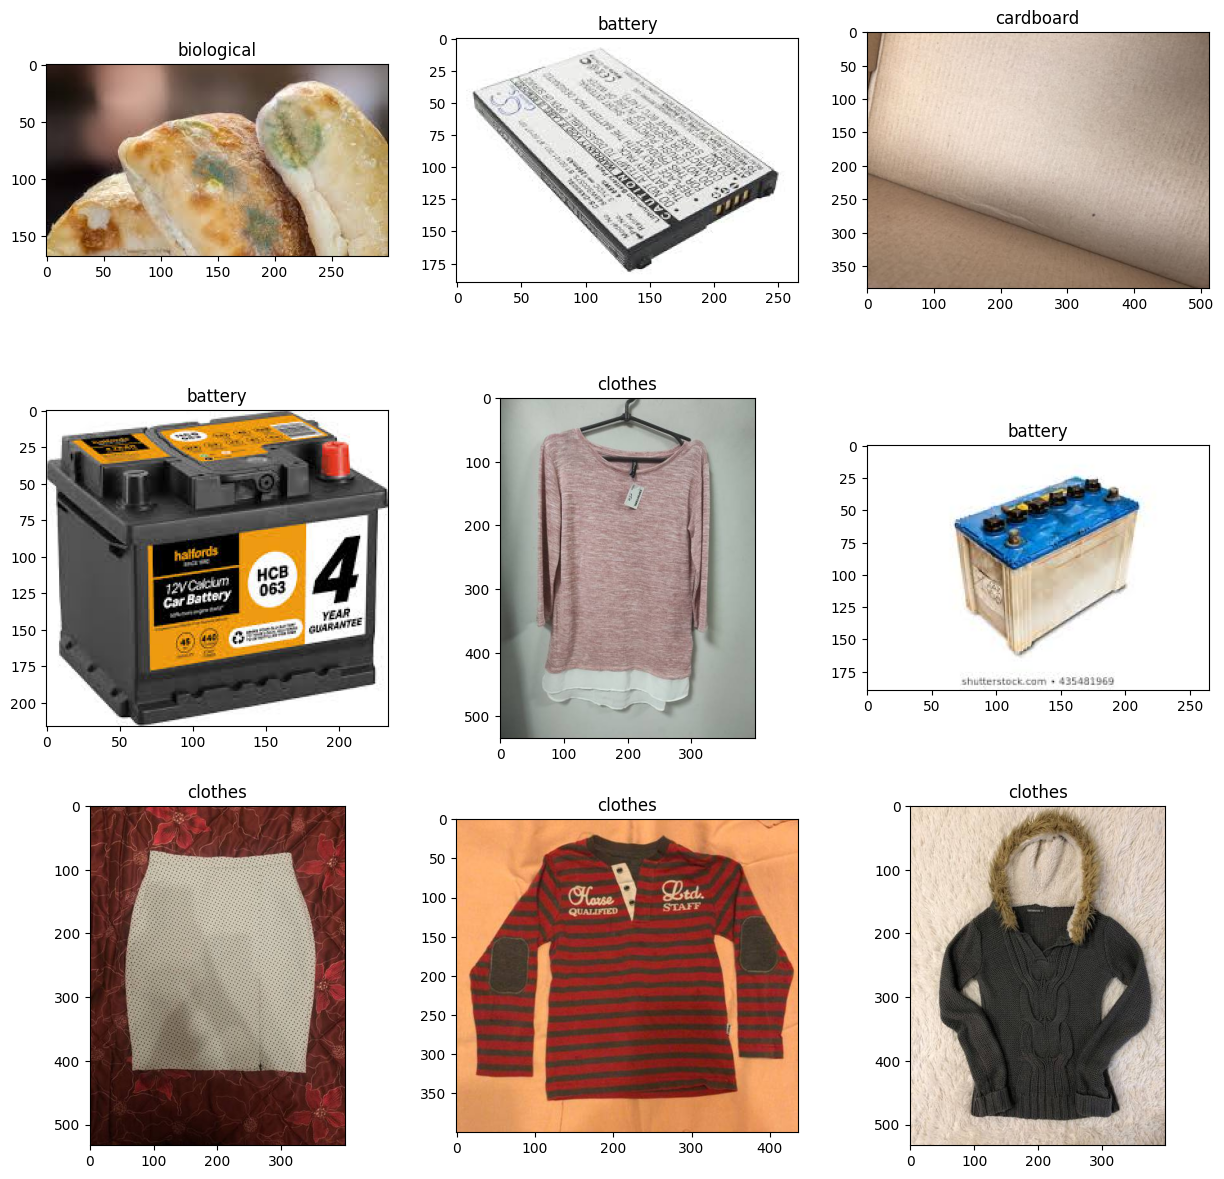

In [7]:
# Sample Data
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = load_img(os.path.join(base_path, sample['filename']))
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

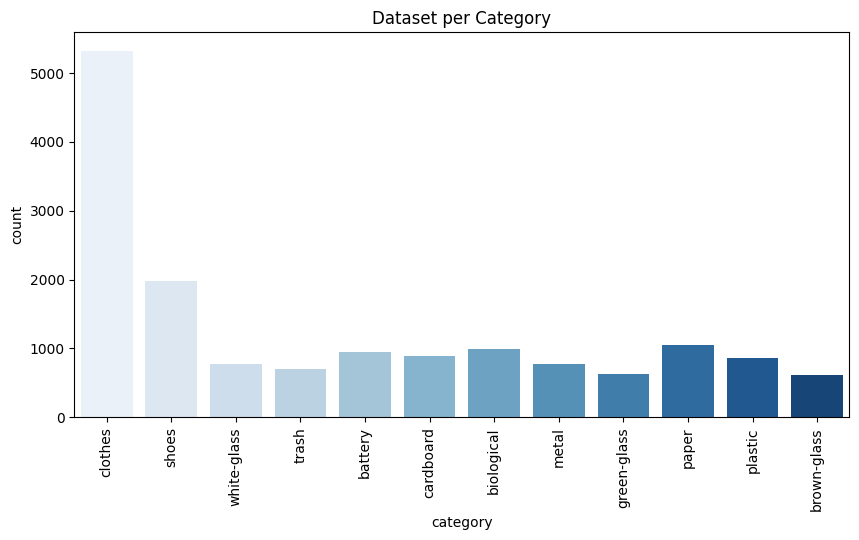

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Dataset per Category')
plt.show()

In [9]:
#Spliting dataset
train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed) # Training set - 80%, Validation set 20%
"""
Then, split Validation set (20%) into:
    Validation set - 10%
    Test set - 10%
"""
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=seed) 

# Reset index to default
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

len(train_df), len(val_df), len(test_df)

(12412, 1551, 1552)

In [10]:
# For generating our data using efficientNet preprocessing
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [11]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 12412 validated image filenames belonging to 12 classes.


In [12]:
val_generator = data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    class_mode='categorical',
    batch_size=batch_size,
    seed=seed)

Found 1551 validated image filenames belonging to 12 classes.


In [13]:
test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=im_shape,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=seed)

Found 1552 validated image filenames belonging to 12 classes.


## Training a model

### Pre-trained

In [14]:
# Import pre-trained model, EfficientNetV2B0 (smallest version), with ImageNet weight
base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=[im_shape[0], im_shape[1], 3],
    pooling=None,
    classes=12,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [15]:
# Freeze all pre-trained model
base_model.trainable = False

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_drop[0][0]',           
          

                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 384)  36864       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 384)  1536       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_d

 block5b_dwconv2 (DepthwiseConv  (None, 14, 14, 672)  6048       ['block5b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 672)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 672)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
          

                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
          

                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 192)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 192)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6f_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6h_expand_activation[0][0]
 2D)      

### Fine-tuning

In [36]:
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(1e-5) # learning rate = 1e-5
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:
%%time
epochs = 30

#Callback to save the best model
callbacks_list = [
    ModelCheckpoint(filepath='model.h5',monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=val_generator,
        verbose = 1,
        validation_steps=val_generator.n // batch_size)

Epoch 1/30
193/193 [==============================] - ETA: 0s - loss: 1.1837 - accuracy: 0.7271
Epoch 1: val_loss improved from inf to 0.57894, saving model to model.h5
193/193 [==============================] - 405s 2s/step - loss: 1.1837 - accuracy: 0.7271 - val_loss: 0.5789 - val_accuracy: 0.8945
Epoch 2/30
193/193 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.9251
Epoch 2: val_loss improved from 0.57894 to 0.33986, saving model to model.h5
193/193 [==============================] - 381s 2s/step - loss: 0.4012 - accuracy: 0.9251 - val_loss: 0.3399 - val_accuracy: 0.9238
Epoch 3/30
193/193 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9556
Epoch 3: val_loss improved from 0.33986 to 0.25738, saving model to model.h5
193/193 [==============================] - 357s 2s/step - loss: 0.2451 - accuracy: 0.9556 - val_loss: 0.2574 - val_accuracy: 0.9355
Epoch 4/30
193/193 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 

In [38]:
# Training curves
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Load Model

In [14]:
model = load_model('model.h5')

## Evaluation

In [15]:
# Model evaluation on test set
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1552/1552 [==============================] - 157s 99ms/step - loss: 0.0330 - accuracy: 0.9884
Test loss: 0.033047087490558624
Test accuracy: 0.9884020686149597


In [16]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Truth label')
    plt.xlabel('Predicted label')

1552/1552 [==============================] - 154s 97ms/step


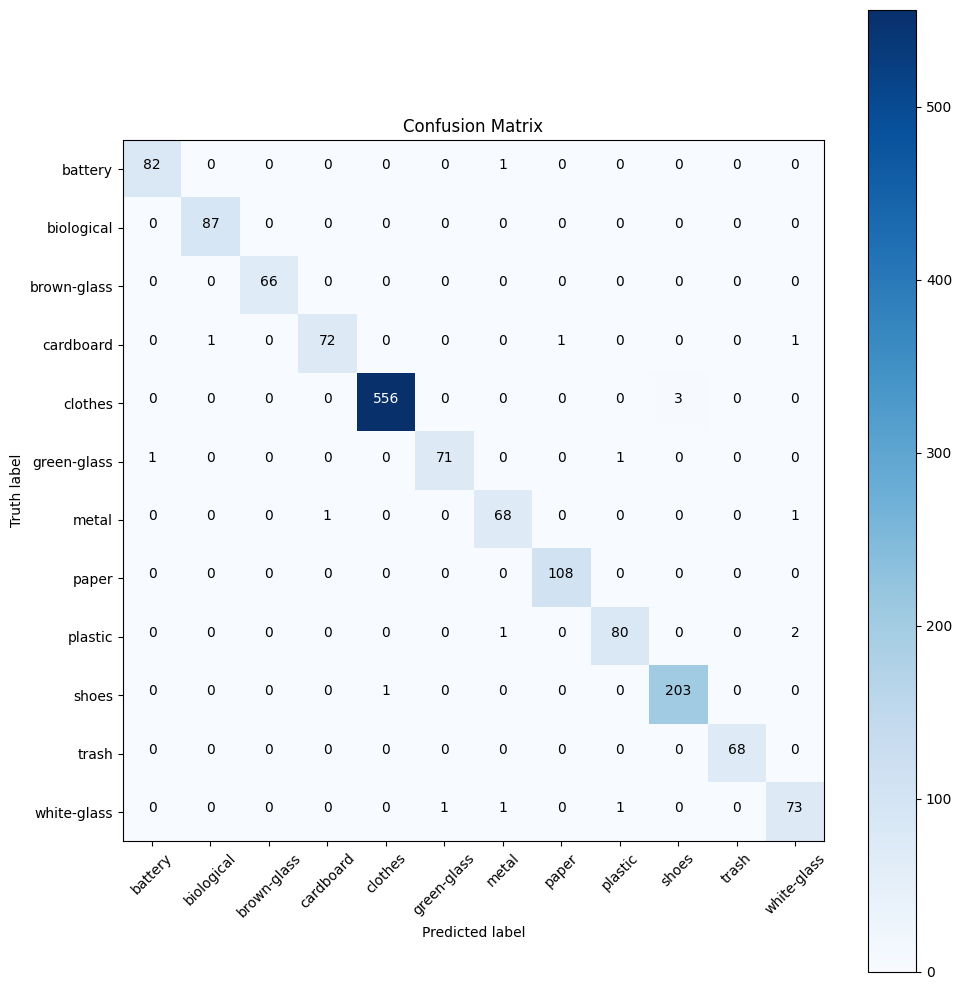

In [17]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = categories

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

## Prediction

In [18]:
from tensorflow.keras.utils import load_img, img_to_array
def predict(image, input_size=(224,224)):
    """
    Predict a class for an image
    Inputs: image
            input_size - resize image for model input
    """
    img = load_img(image, target_size=input_size) # Load image
    img = img_to_array(img) # convert image to numpy array
    img = np.expand_dims(img, axis=0)
    return model.predict(img, batch_size=1)

In [22]:
result = predict('sample.jpg', im_shape)

1/1 [==============================] - 0s 127ms/step


In [23]:
# probability for each classes (12 classes)
print(result)

[[1.7898748e-02 4.0126400e-04 1.1684428e-03 3.5250869e-05 3.3182764e-04
  7.7100277e-01 6.4757422e-02 2.1398551e-04 4.6964407e-02 1.9767827e-04
  5.7424910e-02 3.9603245e-02]]


In [24]:
# Get index of a class with max probability
predict_index = np.argmax(result)
predict_result = (categories[predict_index], result[0][predict_index])
# Prediction class, Confidence
print("Prediction: {} {:0.2f}%".format(predict_result[0], (predict_result[1] * 100)))

Prediction: green-glass 77.10%
